NRES Signal to  trend analysis
---

Plot normalized signal to noise as repoprted by NRES pipeline.

Input: a number of input files containing the signal to noise for starts:

   Format:
   STAR_NAME  Vmag  SN   Texp
       
Code will calculate the S/N normalized to a 60 sec exposure. However, this calculation assumes that 
exposurs remain shot noise dominated in this process, i.e., this calculation is somewhat off. 



In [196]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
import dateutil.parser
import glob
import tarfile
import tempfile
import os
import PyPDF2
import re
import shutil

from astroquery.simbad import Simbad
plt.rcParams["figure.figsize"] = (10,6)
from matplotlib import style
plt.style.use('ggplot')

In [197]:

def readdata (fname):
    
    data = np.genfromtxt (fname, unpack=True, dtype=None, 
                          skip_footer=0, names=['star','vmag','sn','texp'])
    sn60 = data['sn'] * np.sqrt (60. / data['texp'])
    return data['vmag'], sn60


def snmodel (s0=180000, ron=5):
    x = np.arange (2,10,0.5)
    s = 10 ** (-0.4 * x) * s0
    sn = s / np.sqrt (s + 3 * ron ** 2)
    return x, sn


def plotfile (fname, color, label, refflux, ron=5):
    (v,sn) = readdata (fname)
    plt.semilogy (v,sn,'o', color=color, label=label)
    (x,sn) = snmodel (refflux,ron)
    plt.semilogy (x,sn, color=color)

Tired of opening all those pdf files and reading the S/N value from the pipeline? Are you tired of looking up the star's magnitude and adding it to a ascii table yourself? 
Yeah, me too. Now, just tell the procedure where you mount the nres data, which site, camera, and date you want to crawl, and it will do the rest for yu. Even the V magnitude will be grabbed from SIMBAD for you, if the name is resolvable.The output file name can then be read in for pretty plotting. 

In [218]:
def crawldata (site, nres, date, mountpoint='/nfs/archive/engineering', outputname = 'nressn.dat'):
    """
        Crawl through a nres calibrated files directory and 
        (i) extract tar.gz, 
        (ii) read pdf summary plot file and aprse target name, exposure time, s/n
        (iii) query sinbad for v magnitude
        (iv) write output to text file
    """
    
    searchterm = '%s/%s/%s/%s/specproc/*.tar.gz' % (mountpoint, site, nres, date)
    
    starnames = []
    starmags = []
    starsns = []
    starexptimes = []
    
    tgzs = glob.glob (searchterm)
    for tgz in tgzs[0:]:
        with tarfile.open (tgz) as tf:
            bname = os.path.basename(tgz)[0:-7]
            tmpdir=tempfile.mkdtemp()
            tf.extractall (tmpdir)
            tf.close
        
        with open ('%s/%s/%s.pdf' % (tmpdir, bname, bname), 'rb') as pdffile:
            
            # Read the text content from pdf file, deeply burried in the tar ball.
            pdfreader = pdfreader = PyPDF2.PdfFileReader (pdffile)
            text = pdfreader.getPage(0).extractText()
            pdffile.close()
            shutil.rmtree(tmpdir)
            
            # parse the output with an easy to read regex.
            regex = '^([\w_\s-]+)\,\s.+expt =\s?(\d+) s\,.+N=\s?(\d+\.\d+),'
            m = re.search (regex, text)
            if m is not None:
                
                starname = m.group(1)
                exptime  = m.group(2)
                sn       = m.group(3)
            else:
                print ("%s/%s pdf regex match failed" % (tmpdir, bname))
                print ("Input:\n%s\n%s" % (text, regex))
                continue
    
            # Query SIMBAD for the stellar magnitude
            mag = 99
            try:
                customSimbad = Simbad()
                customSimbad.add_votable_fields('flux(V)')
                
                result = customSimbad.query_object(starname if _ not in starname else starname[0:starname.find('_')-1])
                mag = result['FLUX_V'][0]             
            except Exception as e:
                print ("Query failed", e)
                
            # Log, and add everything to internal storge
            starname = starname.replace (' ','_')
            print bname, starname, mag, sn, exptime
            starnames.append (starname)
            starsns.append (sn)
            starexptimes.append (exptime)
            starmags.append (mag)      
            
    # And finally, write everything out to a text file for future use. 
    with open(outputname, "w+") as myfile:
        for ii in range (len (starnames)):
              myfile.write ('%s %s %s %s\n' %( starnames[ii], starmags[ii], starsns[ii], starexptimes[ii]) )  
        


In [223]:
crawldata ('lsc', 'nres01', '20171018', outputname='nres01-20171018.txt')
crawldata ('elp', 'nres02', '20171018', outputname='nres02-20171018.txt')

lscnrs01-fl09-20171018-0031-e91 HR7950_TEMPL 6.049 145.4 300
lscnrs01-fl09-20171018-0032-e91 HR7950_TEMPL 6.049 150.5 300
lscnrs01-fl09-20171018-0033-e91 HD_187691 8.39 51.4 180
lscnrs01-fl09-20171018-0034-e91 HD_187691 8.39 52.1 180
lscnrs01-fl09-20171018-0035-e91 HD_206860 8.46 35.2 300
lscnrs01-fl09-20171018-0036-e91 HD_206860 8.46 37.7 300
('Query failed', TypeError("'NoneType' object has no attribute '__getitem__'",))
lscnrs01-fl09-20171018-0037-e91 HE_2123-0329 99 10.4 1200
lscnrs01-fl09-20171018-0038-e91 HD_17051 9.772 49.0 180
lscnrs01-fl09-20171018-0039-e91 HD_17051 9.772 42.7 180
lscnrs01-fl09-20171018-0040-e91 HD_22049 8.69 116.9 180
lscnrs01-fl09-20171018-0041-e91 HD_22049 8.69 118.1 180
lscnrs01-fl09-20171018-0042-e91 HD_20630 8.98 74.9 180
lscnrs01-fl09-20171018-0043-e91 HD_20630 8.98 77.1 180
lscnrs01-fl09-20171018-0044-e91 HD_30495 10.36 76.2 300
lscnrs01-fl09-20171018-0045-e91 HD_30495 10.36 73.5 300
lscnrs01-fl09-20171018-0046-e91 HD_26913 8.61 51.7 600
lscnrs01-fl09-

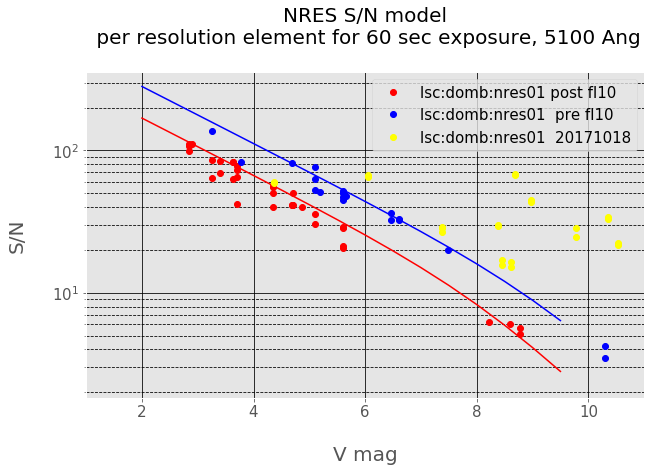

In [228]:

ron=5

fig, ax = plt.subplots(1)

plotfile ('nressn_postfl10.txt', color='red', label='lsc:domb:nres01 post fl10', refflux=180000)
plotfile ('nressn_prefl10.txt' , color='blue', label='lsc:domb:nres01  pre fl10', refflux=500000)
plotfile ('nres01-20171018.txt' , color='yellow', label='lsc:domb:nres01  20171018', refflux=0)

plt.legend(  fontsize=15)
plt.xlim([1,11])
plt.xlabel ( "\nV mag",  fontsize=20)
plt.ylabel ("S/N\n",  fontsize=20)
plt.title ("NRES S/N model\n per resolution element for 60 sec exposure, 5100 Ang\n",  fontsize=20)

ax.grid(b=True, which='major', color='k', linestyle='-')
ax.grid(b=True, which='minor', color='k', linestyle='--')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=10)
plt.subplots_adjust(top=0.88)
plt.savefig("nressn_20171018.png", bbox_inches="tight");  